## 📦 Step 1: Importar Librerías y Configuración

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import signal
from scipy.interpolate import interp1d
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio, display
from pathlib import Path
import os

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas correctamente")
print(f"PyTorch versión: {torch.__version__}")

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 GPU NVIDIA detectada (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 GPU Apple Silicon detectada (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Usando CPU")

print(f"🖥️  Dispositivo de cómputo: {device}")

✅ Librerías importadas correctamente
PyTorch versión: 2.9.1
🍎 GPU Apple Silicon detectada (MPS)
🖥️  Dispositivo de cómputo: mps


## ⚙️ Step 2: Configuración de Parámetros (V02 - Mejorada)

In [15]:
# ============================================
# CONFIGURACIÓN DEL PIPELINE V02
# ============================================

# Rutas
AUDIO_DIR = Path("../VCTK-Corpus/VCTK/Dataset_2Seg")
MODEL_PATH = Path("../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth")
OUTPUT_DIR = Path("./output_v02")
OUTPUT_DIR.mkdir(exist_ok=True)

# Parámetros de segmentación - OVERLAP AUMENTADO
CHUNK_SIZE = 5000          # Muestras por chunk (alta resolución)
OVERLAP = 1000             # ⬆️ AUMENTADO: 1000 muestras (~21ms a 48kHz)
HOP_SIZE = CHUNK_SIZE - OVERLAP  # Paso entre chunks (4000)

# Parámetros de downsampling
INPUT_SIZE = 1000          # Tamaño de entrada al modelo (baja resolución)
OUTPUT_SIZE = 5000         # Tamaño de salida del modelo (alta resolución)
DOWNSAMPLE_FACTOR = CHUNK_SIZE // INPUT_SIZE  # Factor 5x

# ❌ SIN FILTRO ANTI-ALIASING EN ESTA VERSIÓN
USE_ANTIALIASING = False   # Desactivado en V02

# Verificar rutas
print("="*60)
print("CONFIGURACIÓN DEL PIPELINE V02 (SIN ANTI-ALIASING)")
print("="*60)
print(f"📂 Directorio de audio: {AUDIO_DIR}")
print(f"📂 Audio existe: {AUDIO_DIR.exists()}")
print(f"🧠 Ruta del modelo: {MODEL_PATH}")
print(f"🧠 Modelo existe: {MODEL_PATH.exists()}")
print(f"💾 Directorio de salida: {OUTPUT_DIR}")
print("\n--- Parámetros de Segmentación (Mejorados) ---")
print(f"📊 Chunk size: {CHUNK_SIZE} muestras")
print(f"📊 Overlap: {OVERLAP} muestras (⬆️ aumentado para transiciones suaves)")
print(f"📊 Hop size: {HOP_SIZE} muestras")
print("\n--- Parámetros de Downsampling ---")
print(f"⬇️  Factor de downsampling: {DOWNSAMPLE_FACTOR}x")
print(f"⬇️  Input size (low-res): {INPUT_SIZE} muestras")
print(f"⬆️  Output size (high-res): {OUTPUT_SIZE} muestras")
print(f"🔇 Anti-aliasing: {'Activado' if USE_ANTIALIASING else '❌ DESACTIVADO'}")
print("="*60)

# Listar archivos de audio disponibles
audio_files = sorted([f for f in AUDIO_DIR.glob("*.wav")])
print(f"\n📁 Total de archivos WAV disponibles: {len(audio_files)}")
if len(audio_files) > 0:
    print(f"   Primeros 5: {[f.name for f in audio_files[:5]]}")

CONFIGURACIÓN DEL PIPELINE V02 (SIN ANTI-ALIASING)
📂 Directorio de audio: ../VCTK-Corpus/VCTK/Dataset_2Seg
📂 Audio existe: True
🧠 Ruta del modelo: ../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth
🧠 Modelo existe: True
💾 Directorio de salida: output_v02

--- Parámetros de Segmentación (Mejorados) ---
📊 Chunk size: 5000 muestras
📊 Overlap: 1000 muestras (⬆️ aumentado para transiciones suaves)
📊 Hop size: 4000 muestras

--- Parámetros de Downsampling ---
⬇️  Factor de downsampling: 5x
⬇️  Input size (low-res): 1000 muestras
⬆️  Output size (high-res): 5000 muestras
🔇 Anti-aliasing: ❌ DESACTIVADO

📁 Total de archivos WAV disponibles: 2411
   Primeros 5: ['p225_033.wav', 'p225_039.wav', 'p225_051.wav', 'p225_123.wav', 'p225_193.wav']


## 🏗️ Step 3: Definir Arquitectura del Modelo CNN

In [16]:
class TimeSeriesSRNet(nn.Module):
    """
    Convolutional Neural Network for Super-Resolution of Time Series.
    """
    def __init__(self, input_size=1000, output_size=5000, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # ==================== ENCODER ====================
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # ==================== UPSAMPLER ====================
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.upsample(features)
        return output

print("✅ Arquitectura TimeSeriesSRNet definida")

✅ Arquitectura TimeSeriesSRNet definida


## 📥 Step 4: Cargar Modelo Pre-entrenado

In [17]:
# Crear instancia del modelo
model = TimeSeriesSRNet(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)

# Cargar pesos pre-entrenados
if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Modelo cargado desde checkpoint (época {checkpoint.get('epoch', 'N/A')})")
        if checkpoint.get('val_loss'):
            print(f"   Val Loss guardado: {checkpoint.get('val_loss'):.6f}")
    else:
        model.load_state_dict(checkpoint)
        print(f"✅ Modelo cargado (state_dict directo)")
    
    model.to(device)
    model.eval()
    print(f"   Dispositivo: {device}")
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Parámetros totales: {total_params:,}")
else:
    print(f"❌ ERROR: No se encontró el modelo en {MODEL_PATH}")

✅ Modelo cargado desde checkpoint (época 30)
   Val Loss guardado: 0.084546
   Dispositivo: mps
   Parámetros totales: 412,673


## 🔧 Step 5: Funciones del Pipeline V02 (Mejoradas)

### Cambios principales:
- `downsample_direct()` - Sin filtro anti-aliasing
- `apply_synthesis_window()` - Ventana Hann a todo el chunk
- `recombine_chunks_ola()` - Overlap-Add clásico mejorado

In [18]:
def load_audio(filepath):
    """
    Carga un archivo de audio WAV.
    """
    y, sr = librosa.load(filepath, sr=None)
    return y, sr


def segment_audio_ola(y, chunk_size=5000, hop_size=4000):
    """
    Divide la señal de audio en chunks con solapamiento para OLA.
    Usa padding simétrico para manejar bordes.
    
    Args:
        y: señal de audio
        chunk_size: tamaño de cada chunk
        hop_size: paso entre chunks
    
    Returns:
        chunks: lista de arrays numpy
        positions: posiciones de inicio de cada chunk
        padded_length: longitud de la señal con padding
    """
    overlap = chunk_size - hop_size
    
    # Calcular padding necesario
    # Padding al inicio: overlap/2 para centrar la ventana
    # Padding al final: para completar el último chunk
    pad_start = overlap // 2
    n_chunks = int(np.ceil((len(y) + pad_start) / hop_size))
    padded_length = pad_start + n_chunks * hop_size + (chunk_size - hop_size)
    pad_end = padded_length - len(y) - pad_start
    
    # Aplicar padding simétrico (reflexión)
    y_padded = np.pad(y, (pad_start, pad_end), mode='reflect')
    
    chunks = []
    positions = []
    
    start = 0
    while start + chunk_size <= len(y_padded):
        chunk = y_padded[start:start + chunk_size].copy()
        chunks.append(chunk)
        positions.append(start)
        start += hop_size
    
    return chunks, positions, pad_start, len(y)


def downsample_direct(chunk, target_samples):
    """
    Realiza downsampling DIRECTO usando interpolación lineal.
    SIN filtro anti-aliasing.
    
    Args:
        chunk: señal de entrada (alta resolución)
        target_samples: número de muestras objetivo (baja resolución)
    
    Returns:
        downsampled: señal de baja resolución
    """
    x_original = np.linspace(0, 1, len(chunk))
    x_target = np.linspace(0, 1, target_samples)
    interpolator = interp1d(x_original, chunk, kind='linear')
    downsampled = interpolator(x_target)
    return downsampled


def reconstruct_chunk(model, chunk_low_res, device):
    """
    Usa el modelo CNN para reconstruir un chunk de alta resolución.
    """
    x = torch.tensor(chunk_low_res, dtype=torch.float32)
    x = x.unsqueeze(0).unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        y_pred = model(x)
    
    chunk_high_res = y_pred.squeeze().cpu().numpy()
    return chunk_high_res


def create_synthesis_window(chunk_size, overlap):
    """
    Crea una ventana de síntesis para Overlap-Add.
    La ventana es 1 en el centro y decae suavemente en los bordes.
    
    Esta ventana cumple la propiedad COLA (Constant Overlap-Add):
    La suma de ventanas solapadas = 1 en toda la señal.
    
    Args:
        chunk_size: tamaño del chunk
        overlap: tamaño del solapamiento
    
    Returns:
        window: ventana de síntesis
    """
    window = np.ones(chunk_size)
    
    # Crear fade-in y fade-out usando raised cosine (más suave que Hann)
    fade_length = overlap
    
    # Fade-in: 0 -> 1 en los primeros 'overlap' samples
    fade_in = 0.5 * (1 - np.cos(np.pi * np.arange(fade_length) / fade_length))
    
    # Fade-out: 1 -> 0 en los últimos 'overlap' samples  
    fade_out = 0.5 * (1 + np.cos(np.pi * np.arange(fade_length) / fade_length))
    
    window[:fade_length] = fade_in
    window[-fade_length:] = fade_out
    
    return window


def recombine_chunks_ola(chunks, positions, chunk_size, overlap, pad_start, original_length):
    """
    Recombina chunks usando Overlap-Add (OLA) mejorado.
    
    Cada chunk se multiplica por una ventana de síntesis antes de sumarse.
    Esto elimina discontinuidades en las transiciones.
    
    Args:
        chunks: lista de chunks procesados
        positions: posiciones de inicio de cada chunk
        chunk_size: tamaño de cada chunk
        overlap: tamaño del solapamiento
        pad_start: padding agregado al inicio
        original_length: longitud original de la señal
    
    Returns:
        output: señal reconstruida
    """
    # Crear ventana de síntesis
    window = create_synthesis_window(chunk_size, overlap)
    
    # Calcular longitud total del buffer
    total_length = positions[-1] + chunk_size if chunks else 0
    
    # Inicializar buffers
    output = np.zeros(total_length)
    window_sum = np.zeros(total_length)  # Para normalización COLA
    
    # Overlap-Add: multiplicar por ventana y sumar
    for chunk, pos in zip(chunks, positions):
        end_pos = pos + chunk_size
        
        # Aplicar ventana al chunk
        windowed_chunk = chunk * window
        
        # Sumar al buffer de salida
        output[pos:end_pos] += windowed_chunk
        window_sum[pos:end_pos] += window
    
    # Normalizar donde la suma de ventanas > 0
    # Esto asegura que la amplitud sea correcta
    valid_mask = window_sum > 1e-8
    output[valid_mask] /= window_sum[valid_mask]
    
    # Remover padding y recortar a longitud original
    output = output[pad_start:pad_start + original_length]
    
    return output


print("✅ Funciones del pipeline V02 definidas:")
print("   - load_audio()")
print("   - segment_audio_ola() - con padding simétrico")
print("   - downsample_direct() - SIN anti-aliasing")
print("   - reconstruct_chunk()")
print("   - create_synthesis_window() - ventana raised cosine")
print("   - recombine_chunks_ola() - Overlap-Add mejorado")

✅ Funciones del pipeline V02 definidas:
   - load_audio()
   - segment_audio_ola() - con padding simétrico
   - downsample_direct() - SIN anti-aliasing
   - reconstruct_chunk()
   - create_synthesis_window() - ventana raised cosine
   - recombine_chunks_ola() - Overlap-Add mejorado


## 🚀 Step 6: Pipeline Completo V02

In [19]:
def full_reconstruction_pipeline_v02(audio_path, model, device, 
                                      chunk_size=5000, overlap=1000,
                                      input_size=1000, verbose=True):
    """
    Pipeline V02: Sin anti-aliasing + OLA mejorado.
    
    Args:
        audio_path: ruta al archivo de audio
        model: modelo CNN pre-entrenado
        device: dispositivo de cómputo
        chunk_size: tamaño de chunks (alta resolución)
        overlap: solapamiento entre chunks (aumentado)
        input_size: tamaño de entrada al modelo (baja resolución)
        verbose: imprimir información de progreso
    
    Returns:
        original: señal original
        degraded: señal degradada (sin reconstruir)
        reconstructed: señal reconstruida
        sr: sample rate
    """
    hop_size = chunk_size - overlap
    
    # 1. Cargar audio
    if verbose:
        print(f"📥 Cargando audio: {audio_path.name}")
    original, sr = load_audio(audio_path)
    original_length = len(original)
    
    if verbose:
        duration = original_length / sr
        print(f"   Duración: {duration:.3f}s, Muestras: {original_length}, SR: {sr} Hz")
    
    # 2. Segmentar con padding para OLA
    if verbose:
        print(f"✂️  Segmentando (OLA): chunks={chunk_size}, overlap={overlap}, hop={hop_size}")
    chunks, positions, pad_start, orig_len = segment_audio_ola(original, chunk_size, hop_size)
    
    if verbose:
        print(f"   Chunks generados: {len(chunks)}")
        print(f"   Padding aplicado: {pad_start} muestras al inicio")
    
    # 3. Procesar cada chunk
    chunks_low_res = []
    chunks_reconstructed = []
    
    for i, chunk in enumerate(chunks):
        # 3a. Downsample DIRECTO (sin anti-aliasing)
        chunk_low = downsample_direct(chunk, input_size)
        chunks_low_res.append(chunk_low)
        
        # 3b. Reconstruir con modelo CNN
        chunk_reconstructed = reconstruct_chunk(model, chunk_low, device)
        chunks_reconstructed.append(chunk_reconstructed)
        
        if verbose and (i + 1) % 5 == 0:
            print(f"   Procesados {i + 1}/{len(chunks)} chunks...")
    
    if verbose:
        print(f"   ✅ Todos los chunks procesados")
    
    # 4. Recombinar con OLA mejorado
    if verbose:
        print(f"🔗 Recombinando con Overlap-Add (OLA)...")
    reconstructed = recombine_chunks_ola(
        chunks_reconstructed, positions, chunk_size, overlap, pad_start, orig_len
    )
    
    # 5. Crear versión degradada para comparación
    chunks_degraded_upsampled = []
    for chunk_low in chunks_low_res:
        x_low = np.linspace(0, 1, len(chunk_low))
        x_high = np.linspace(0, 1, chunk_size)
        interpolator = interp1d(x_low, chunk_low, kind='linear')
        chunks_degraded_upsampled.append(interpolator(x_high))
    
    degraded = recombine_chunks_ola(
        chunks_degraded_upsampled, positions, chunk_size, overlap, pad_start, orig_len
    )
    
    if verbose:
        print(f"✅ Reconstrucción V02 completada")
        print(f"   Longitud original: {len(original)}")
        print(f"   Longitud reconstruida: {len(reconstructed)}")
    
    return original, degraded, reconstructed, sr


print("✅ Pipeline V02 definido: full_reconstruction_pipeline_v02()")

✅ Pipeline V02 definido: full_reconstruction_pipeline_v02()


## 🎵 Step 7: Seleccionar y Procesar Audio de Prueba

In [20]:
# Seleccionar archivo de audio
TEST_INDEX = 0  # Cambiar para probar otros archivos

if len(audio_files) > TEST_INDEX:
    test_audio_path = audio_files[TEST_INDEX]
    print(f"🎵 Archivo seleccionado: {test_audio_path.name}")
    print(f"   Ruta completa: {test_audio_path}")
else:
    print("❌ No hay archivos de audio disponibles")

🎵 Archivo seleccionado: p225_033.wav
   Ruta completa: ../VCTK-Corpus/VCTK/Dataset_2Seg/p225_033.wav


In [21]:
# Ejecutar el pipeline V02
print("="*60)
print("EJECUTANDO PIPELINE V02 (SIN ANTI-ALIASING + OLA MEJORADO)")
print("="*60)

original, degraded, reconstructed, sr = full_reconstruction_pipeline_v02(
    audio_path=test_audio_path,
    model=model,
    device=device,
    chunk_size=CHUNK_SIZE,
    overlap=OVERLAP,
    input_size=INPUT_SIZE,
    verbose=True
)

print("="*60)

EJECUTANDO PIPELINE V02 (SIN ANTI-ALIASING + OLA MEJORADO)
📥 Cargando audio: p225_033.wav
   Duración: 2.000s, Muestras: 96000, SR: 48000 Hz
✂️  Segmentando (OLA): chunks=5000, overlap=1000, hop=4000
   Chunks generados: 25
   Padding aplicado: 500 muestras al inicio
   Procesados 5/25 chunks...
   Procesados 10/25 chunks...
   Procesados 15/25 chunks...
   Procesados 20/25 chunks...
   Procesados 25/25 chunks...
   ✅ Todos los chunks procesados
🔗 Recombinando con Overlap-Add (OLA)...
✅ Reconstrucción V02 completada
   Longitud original: 96000
   Longitud reconstruida: 96000


## 📊 Step 8: Visualización de Resultados

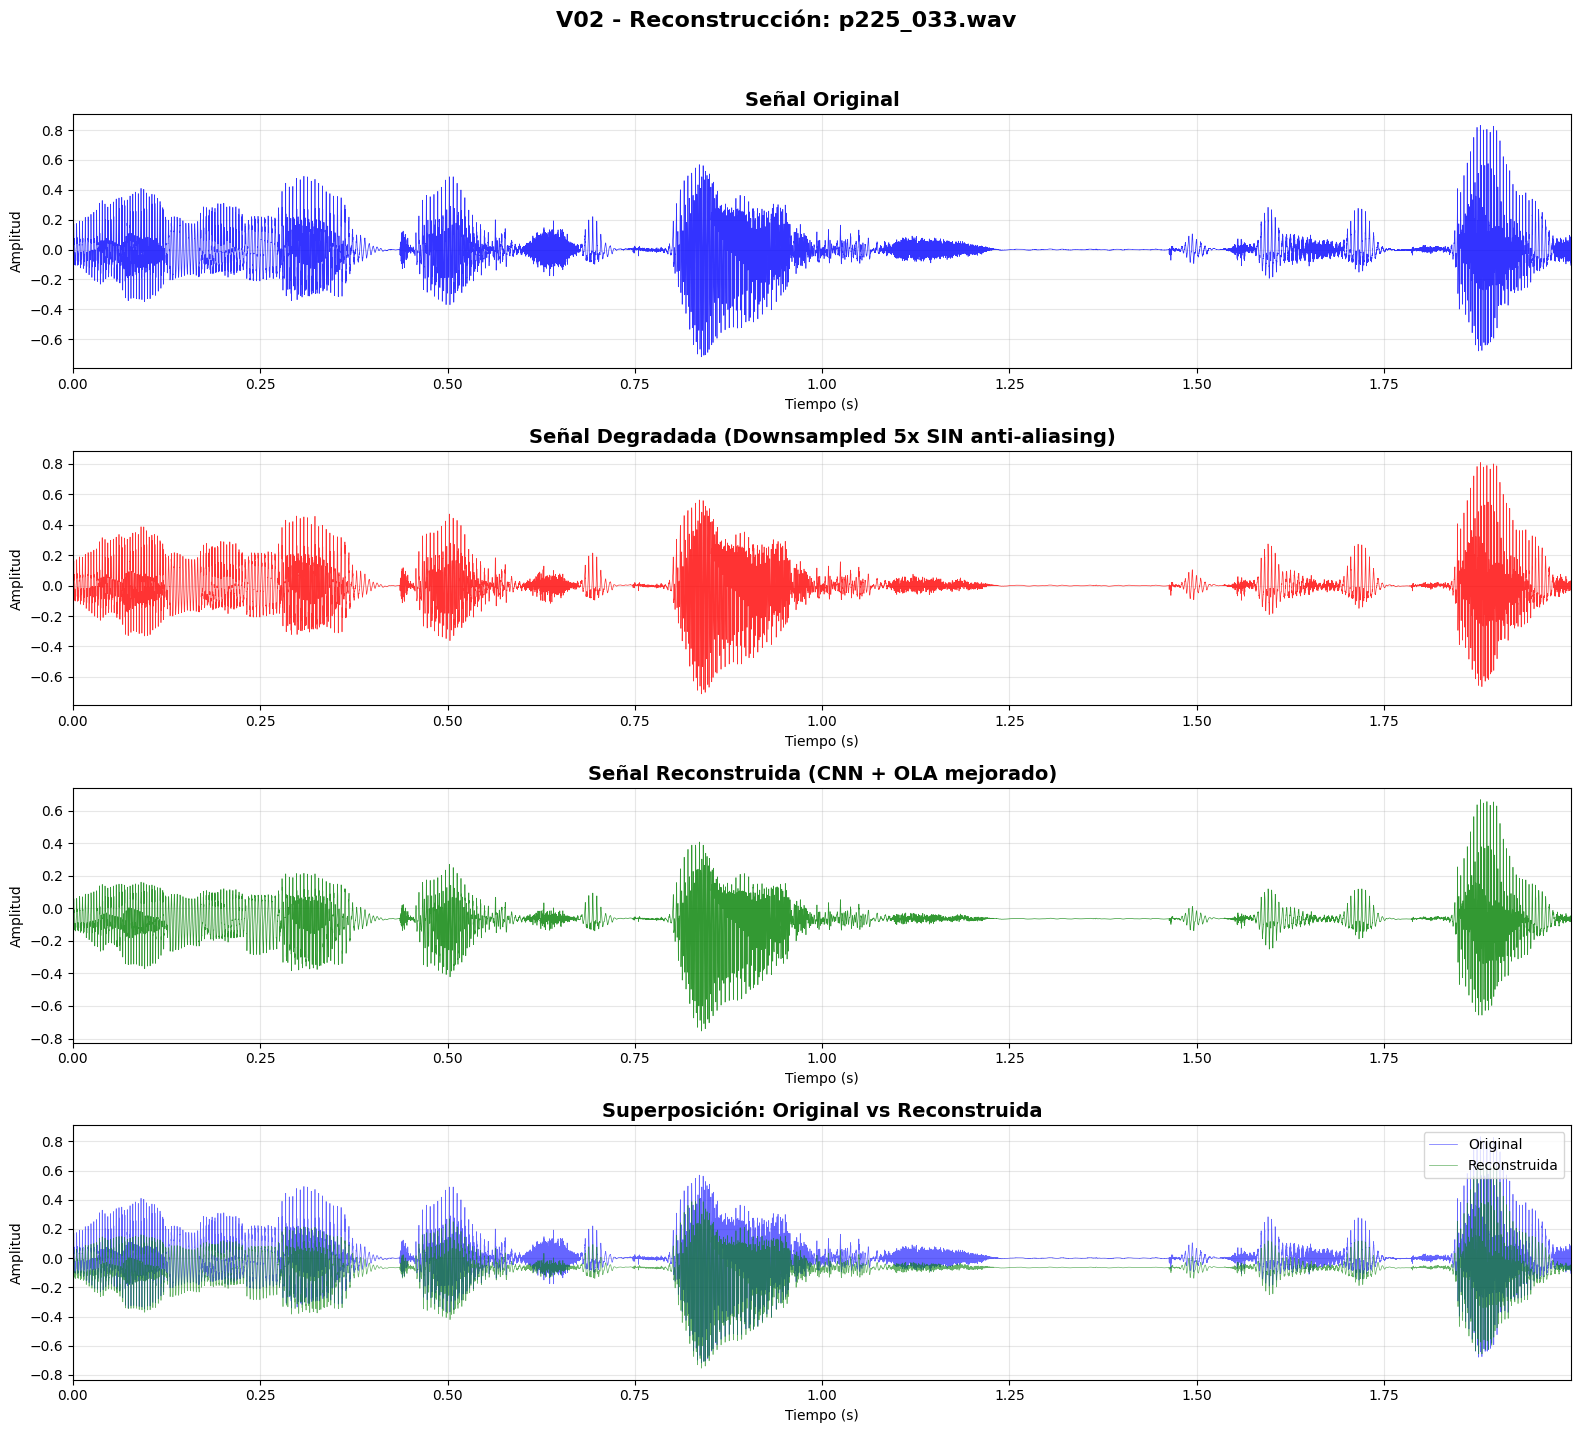

In [22]:
def plot_comparison(original, degraded, reconstructed, sr, title="Comparación de Señales"):
    """
    Visualiza la comparación entre señal original, degradada y reconstruida.
    """
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    time = np.arange(len(original)) / sr
    
    # 1. Señal Original
    axes[0].plot(time, original, color='blue', linewidth=0.5, alpha=0.8)
    axes[0].set_title('Señal Original', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tiempo (s)')
    axes[0].set_ylabel('Amplitud')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, time[-1]])
    
    # 2. Señal Degradada
    time_deg = np.arange(len(degraded)) / sr
    axes[1].plot(time_deg, degraded, color='red', linewidth=0.5, alpha=0.8)
    axes[1].set_title('Señal Degradada (Downsampled 5x SIN anti-aliasing)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tiempo (s)')
    axes[1].set_ylabel('Amplitud')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, time_deg[-1]])
    
    # 3. Señal Reconstruida
    time_rec = np.arange(len(reconstructed)) / sr
    axes[2].plot(time_rec, reconstructed, color='green', linewidth=0.5, alpha=0.8)
    axes[2].set_title('Señal Reconstruida (CNN + OLA mejorado)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Tiempo (s)')
    axes[2].set_ylabel('Amplitud')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim([0, time_rec[-1]])
    
    # 4. Superposición
    min_len = min(len(original), len(reconstructed))
    time_overlay = np.arange(min_len) / sr
    axes[3].plot(time_overlay, original[:min_len], color='blue', linewidth=0.5, alpha=0.6, label='Original')
    axes[3].plot(time_overlay, reconstructed[:min_len], color='green', linewidth=0.5, alpha=0.6, label='Reconstruida')
    axes[3].set_title('Superposición: Original vs Reconstruida', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Tiempo (s)')
    axes[3].set_ylabel('Amplitud')
    axes[3].grid(True, alpha=0.3)
    axes[3].legend(loc='upper right')
    axes[3].set_xlim([0, time_overlay[-1]])
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


plot_comparison(original, degraded, reconstructed, sr, 
                title=f"V02 - Reconstrucción: {test_audio_path.name}")

In [23]:
def select_random_regions(original, reconstructed, sr, n_regions=10, region_duration_ms=100):
    """
    Selecciona n regiones aleatorias de la señal para análisis detallado.
    
    Args:
        original: señal original
        reconstructed: señal reconstruida
        sr: sample rate
        n_regions: número de regiones a seleccionar
        region_duration_ms: duración de cada región en milisegundos
    
    Returns:
        regions: lista de tuplas (start_idx, end_idx) para cada región
    """
    region_samples = int(region_duration_ms * sr / 1000)
    max_start = len(original) - region_samples
    
    # Seleccionar n posiciones aleatorias
    np.random.seed(42)  # Para reproducibilidad
    start_indices = np.sort(np.random.randint(0, max_start, n_regions))
    
    regions = [(idx, idx + region_samples) for idx in start_indices]
    return regions, region_samples


def plot_original_regions(original, sr, regions, region_samples):
    """
    Visualiza 10 regiones de la señal original en una grid.
    """
    n_regions = len(regions)
    n_cols = 5
    n_rows = (n_regions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, (start, end) in enumerate(regions):
        ax = axes[idx]
        time = np.arange(start, end) / sr * 1000  # ms
        ax.plot(time, original[start:end], color='blue', linewidth=1.5)
        ax.set_title(f'Region {idx+1} ({start/sr*1000:.0f}-{end/sr*1000:.0f} ms)', fontsize=10, fontweight='bold')
        ax.set_xlabel('Time (ms)', fontsize=9)
        ax.set_ylabel('Amplitude', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for idx in range(n_regions, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Original Signal: 10 Random Regions', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def plot_reconstructed_regions(reconstructed, sr, regions, region_samples):
    """
    Visualiza 10 regiones de la señal reconstruida en una grid.
    """
    n_regions = len(regions)
    n_cols = 5
    n_rows = (n_regions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, (start, end) in enumerate(regions):
        ax = axes[idx]
        time = np.arange(start, end) / sr * 1000  # ms
        ax.plot(time, reconstructed[start:end], color='green', linewidth=1.5)
        ax.set_title(f'Region {idx+1} ({start/sr*1000:.0f}-{end/sr*1000:.0f} ms)', fontsize=10, fontweight='bold')
        ax.set_xlabel('Time (ms)', fontsize=9)
        ax.set_ylabel('Amplitude', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for idx in range(n_regions, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Reconstructed Signal: 10 Random Regions (CNN + OLA)', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def plot_comparison_regions(original, reconstructed, sr, regions, region_samples):
    """
    Visualiza 10 regiones en dos columnas: original (izq) vs reconstruida (der).
    """
    n_regions = len(regions)
    
    fig, axes = plt.subplots(n_regions, 2, figsize=(16, 4*n_regions))
    
    for idx, (start, end) in enumerate(regions):
        time = np.arange(start, end) / sr * 1000  # ms
        
        # Columna izquierda: Original
        ax_orig = axes[idx, 0]
        ax_orig.plot(time, original[start:end], color='blue', linewidth=1.5, label='Original')
        ax_orig.set_title(f'Original - Region {idx+1}', fontsize=11, fontweight='bold')
        ax_orig.set_xlabel('Time (ms)', fontsize=9)
        ax_orig.set_ylabel('Amplitude', fontsize=9)
        ax_orig.grid(True, alpha=0.3)
        ax_orig.legend(loc='upper right', fontsize=9)
        
        # Columna derecha: Reconstruida
        ax_rec = axes[idx, 1]
        ax_rec.plot(time, reconstructed[start:end], color='green', linewidth=1.5, label='Reconstructed')
        ax_rec.set_title(f'Reconstructed - Region {idx+1}', fontsize=11, fontweight='bold')
        ax_rec.set_xlabel('Time (ms)', fontsize=9)
        ax_rec.set_ylabel('Amplitude', fontsize=9)
        ax_rec.grid(True, alpha=0.3)
        ax_rec.legend(loc='upper right', fontsize=9)
    
    plt.suptitle('Signal Comparison: Original vs Reconstructed (10 Random Regions)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


print("✅ Multi-region analysis functions defined:")
print("   - select_random_regions()")
print("   - plot_original_regions()")
print("   - plot_reconstructed_regions()")
print("   - plot_comparison_regions()")


✅ Multi-region analysis functions defined:
   - select_random_regions()
   - plot_original_regions()
   - plot_reconstructed_regions()
   - plot_comparison_regions()


In [24]:
# Seleccionar 10 regiones aleatorias (100ms cada una)
regions, region_samples = select_random_regions(
    original, reconstructed, sr, 
    n_regions=10, 
    region_duration_ms=100
)

print("="*60)
print("SELECTED REGIONS FOR DETAILED ANALYSIS")
print("="*60)
for idx, (start, end) in enumerate(regions):
    print(f"Region {idx+1:2d}: {start/sr*1000:6.0f} - {end/sr*1000:6.0f} ms ({region_samples} samples)")
print("="*60)

SELECTED REGIONS FOR DETAILED ANALYSIS
Region  1:     18 -    118 ms (4800 samples)
Region  2:    131 -    231 ms (4800 samples)
Region  3:    329 -    429 ms (4800 samples)
Region  4:    775 -    875 ms (4800 samples)
Region  5:    919 -   1019 ms (4800 samples)
Region  6:   1143 -   1243 ms (4800 samples)
Region  7:   1255 -   1355 ms (4800 samples)
Region  8:   1600 -   1700 ms (4800 samples)
Region  9:   1716 -   1816 ms (4800 samples)
Region 10:   1823 -   1923 ms (4800 samples)



📊 Generating plot 1: Original signal regions...


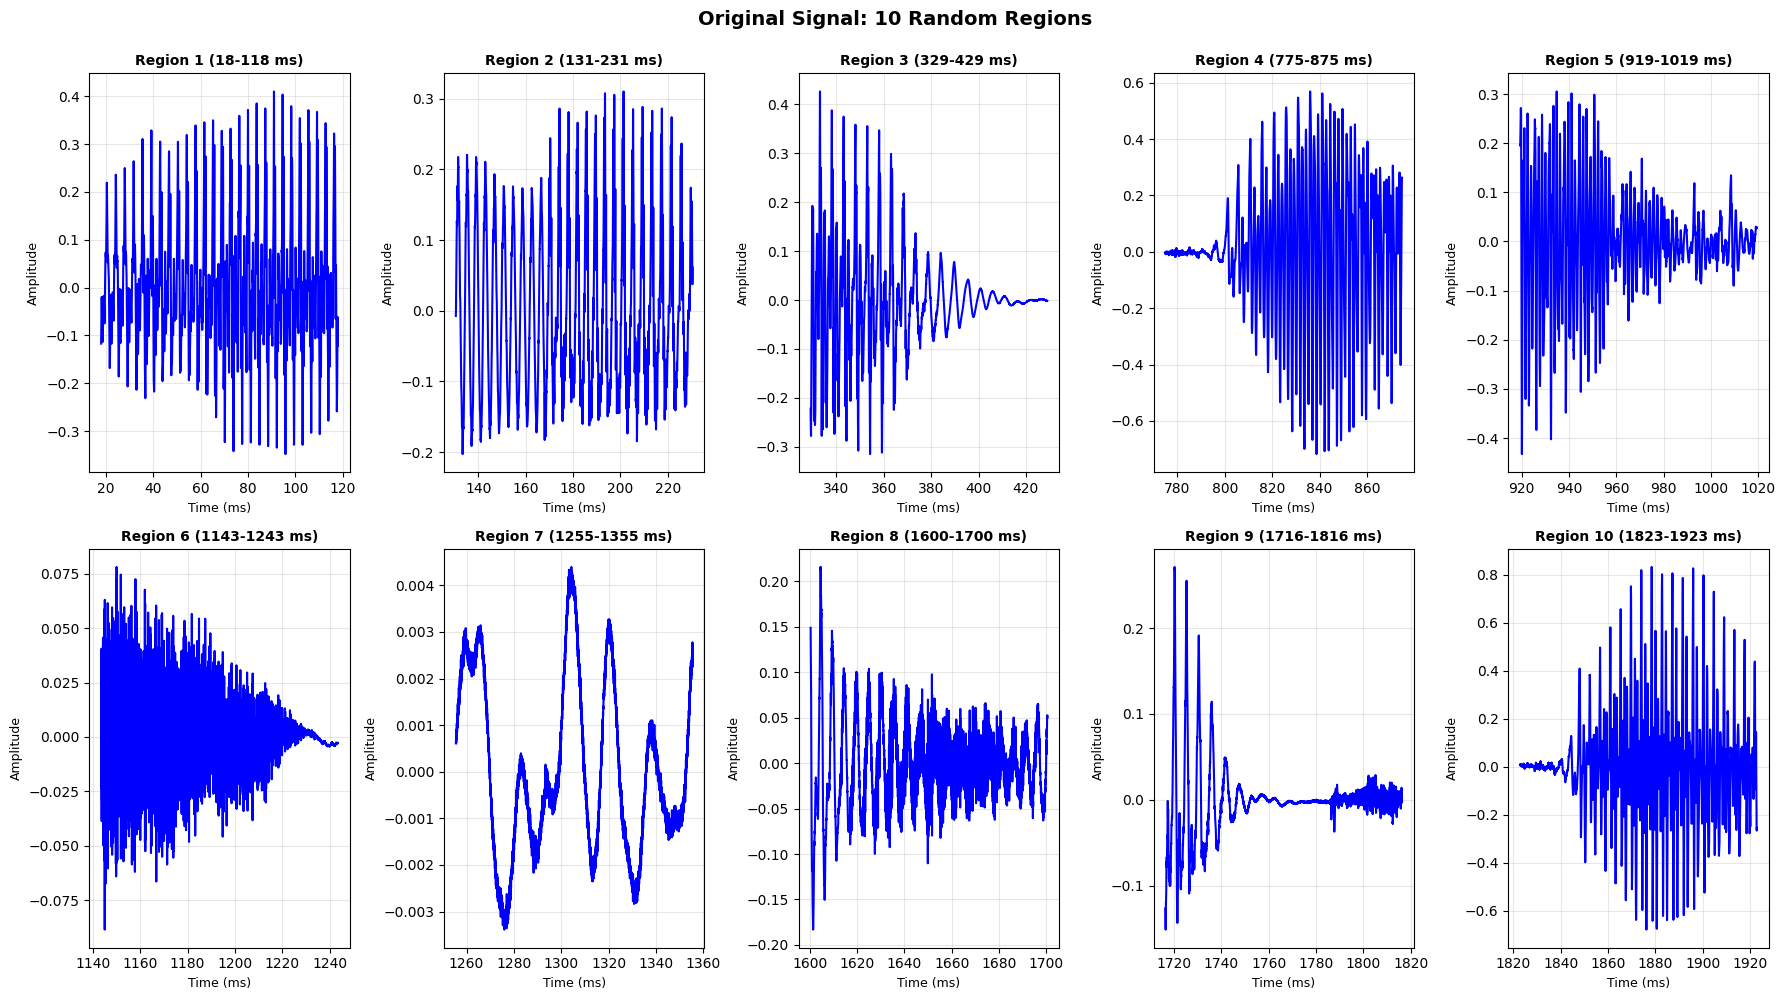

In [25]:
# Gráfico 1: 10 regiones de la señal original
print("\n📊 Generating plot 1: Original signal regions...")
plot_original_regions(original, sr, regions, region_samples)


📊 Generating plot 2: Reconstructed signal regions...


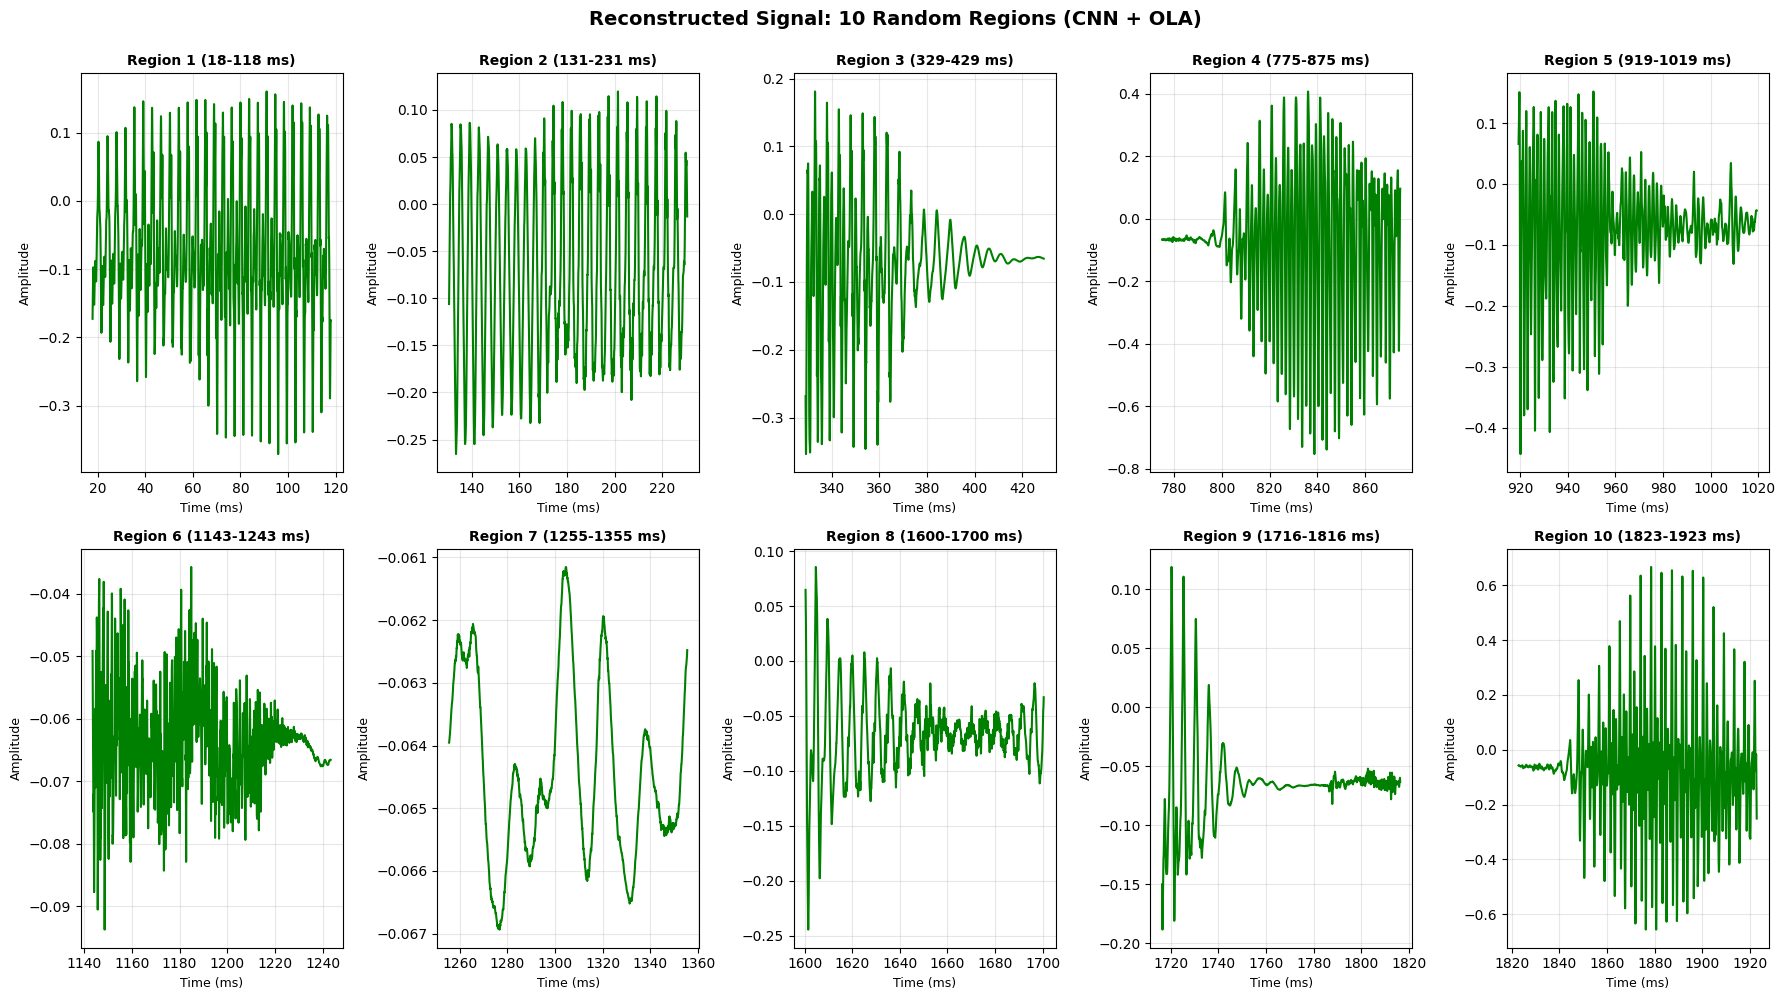

In [26]:
# Gráfico 2: 10 regiones de la señal reconstruida
print("\n📊 Generating plot 2: Reconstructed signal regions...")
plot_reconstructed_regions(reconstructed, sr, regions, region_samples)


📊 Generating plot 3: Side-by-side comparison of all regions...


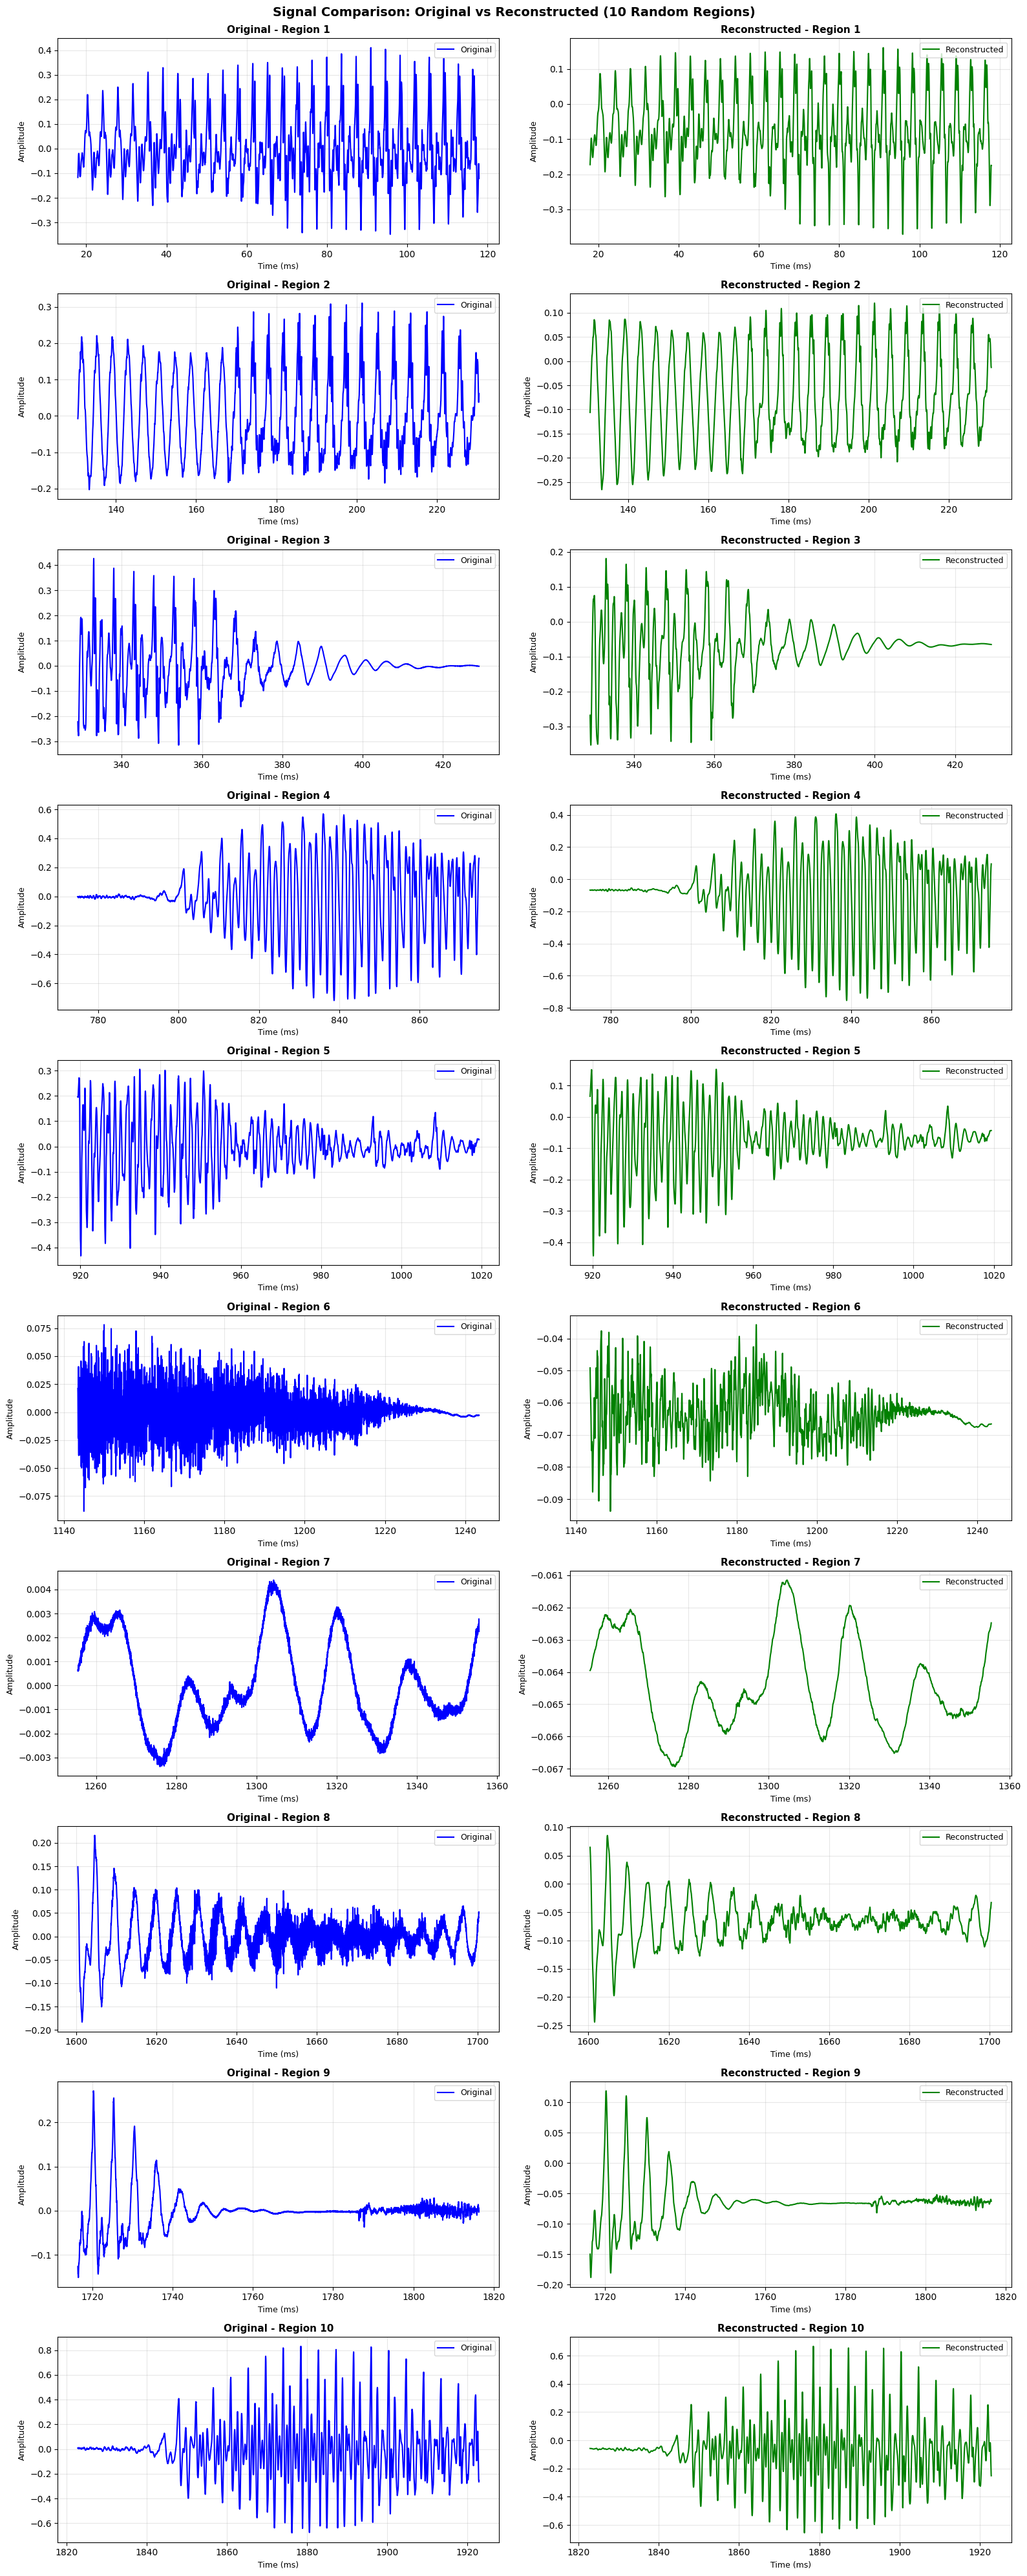


✅ Multi-region analysis complete!


In [27]:
# Gráfico 3: Comparación lado a lado (original vs reconstruida) para cada región
print("\n📊 Generating plot 3: Side-by-side comparison of all regions...")
plot_comparison_regions(original, reconstructed, sr, regions, region_samples)
print("\n✅ Multi-region analysis complete!")

## 📍 Step 8b: Multi-Region Detailed Analysis

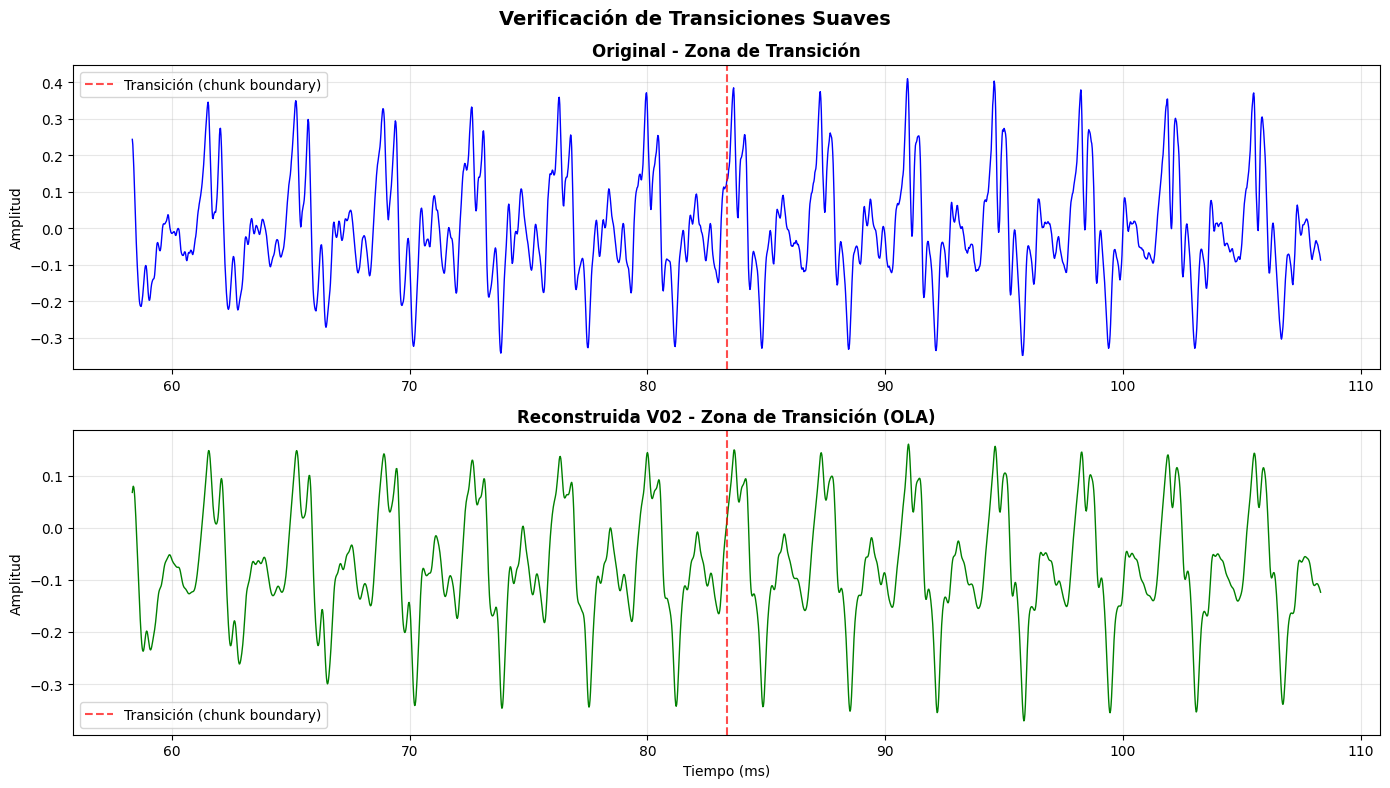

In [28]:
# Zoom para verificar transiciones suaves
def plot_zoom_transitions(original, reconstructed, sr, positions, chunk_size, overlap):
    """
    Visualiza las zonas de transición para verificar que no hay clicks.
    """
    hop_size = chunk_size - overlap
    
    # Encontrar una zona de transición (donde se solapan chunks)
    transition_point = hop_size  # Primera transición
    
    # Mostrar 50ms alrededor de la transición
    window_ms = 50
    window_samples = int(window_ms * sr / 1000)
    
    start = max(0, transition_point - window_samples // 2)
    end = min(len(reconstructed), transition_point + window_samples // 2)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    time = np.arange(start, end) / sr * 1000  # en ms
    
    # Original
    axes[0].plot(time, original[start:end], 'b-', linewidth=1)
    axes[0].axvline(x=transition_point/sr*1000, color='red', linestyle='--', 
                    label=f'Transición (chunk boundary)', alpha=0.7)
    axes[0].set_title('Original - Zona de Transición', fontweight='bold')
    axes[0].set_ylabel('Amplitud')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruida
    axes[1].plot(time, reconstructed[start:end], 'g-', linewidth=1)
    axes[1].axvline(x=transition_point/sr*1000, color='red', linestyle='--',
                    label=f'Transición (chunk boundary)', alpha=0.7)
    axes[1].set_title('Reconstruida V02 - Zona de Transición (OLA)', fontweight='bold')
    axes[1].set_xlabel('Tiempo (ms)')
    axes[1].set_ylabel('Amplitud')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Verificación de Transiciones Suaves', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Mostrar zona de transición
# Nota: positions viene del pipeline, pero usamos valores por defecto aquí
plot_zoom_transitions(original, reconstructed, sr, None, CHUNK_SIZE, OVERLAP)

## 📈 Step 9: Análisis Espectral

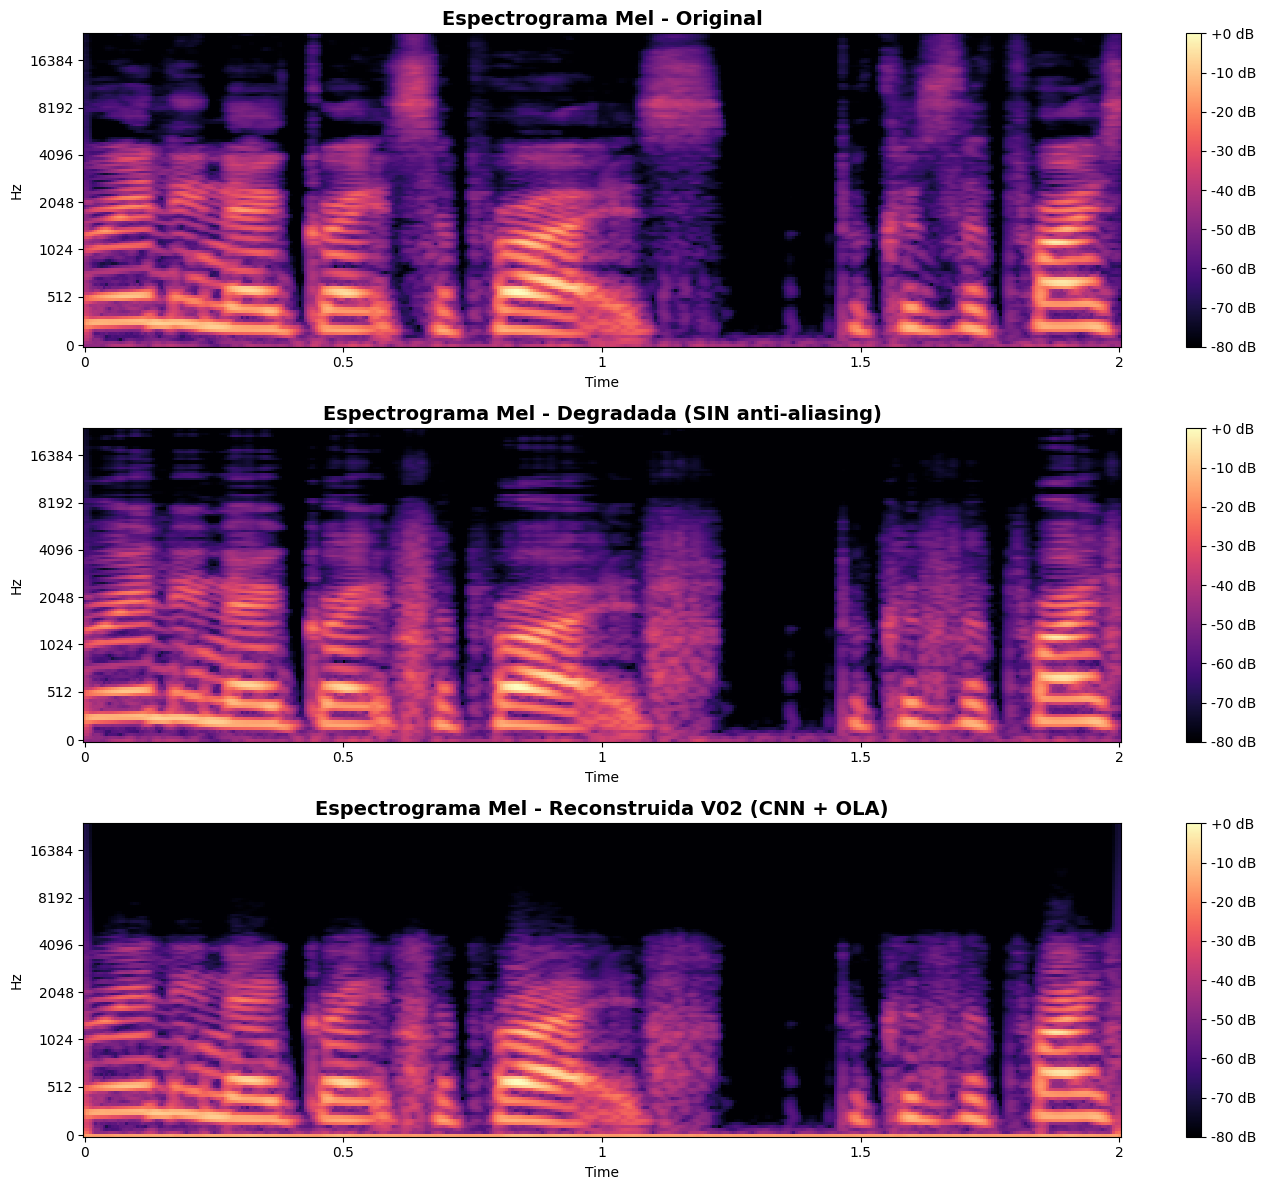

In [29]:
def plot_spectrograms(original, degraded, reconstructed, sr):
    """
    Genera espectrogramas Mel para comparar.
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    n_mels = 128
    hop_length = 256
    
    # Original
    S_orig = librosa.feature.melspectrogram(y=original, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_orig_db = librosa.power_to_db(S_orig, ref=np.max)
    img1 = librosa.display.specshow(S_orig_db, sr=sr, hop_length=hop_length, 
                                     x_axis='time', y_axis='mel', ax=axes[0])
    axes[0].set_title('Espectrograma Mel - Original', fontsize=14, fontweight='bold')
    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    
    # Degradada (sin anti-aliasing -> puede tener aliasing visible)
    S_deg = librosa.feature.melspectrogram(y=degraded, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_deg_db = librosa.power_to_db(S_deg, ref=np.max)
    img2 = librosa.display.specshow(S_deg_db, sr=sr, hop_length=hop_length,
                                     x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title('Espectrograma Mel - Degradada (SIN anti-aliasing)', fontsize=14, fontweight='bold')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    
    # Reconstruida
    S_rec = librosa.feature.melspectrogram(y=reconstructed, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_rec_db = librosa.power_to_db(S_rec, ref=np.max)
    img3 = librosa.display.specshow(S_rec_db, sr=sr, hop_length=hop_length,
                                     x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Espectrograma Mel - Reconstruida V02 (CNN + OLA)', fontsize=14, fontweight='bold')
    fig.colorbar(img3, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()


plot_spectrograms(original, degraded, reconstructed, sr)

## 🔊 Step 10: Escuchar los Audios

In [30]:
print("🎧 AUDIO ORIGINAL")
print(f"   Duración: {len(original)/sr:.3f}s")
display(Audio(original, rate=sr))

🎧 AUDIO ORIGINAL
   Duración: 2.000s


In [31]:
print("🎧 AUDIO DEGRADADO (Sin anti-aliasing)")
print(f"   Duración: {len(degraded)/sr:.3f}s")
display(Audio(degraded, rate=sr))

🎧 AUDIO DEGRADADO (Sin anti-aliasing)
   Duración: 2.000s


In [32]:
print("🎧 AUDIO RECONSTRUIDO V02 (CNN + OLA mejorado)")
print(f"   Duración: {len(reconstructed)/sr:.3f}s")
display(Audio(reconstructed, rate=sr))

🎧 AUDIO RECONSTRUIDO V02 (CNN + OLA mejorado)
   Duración: 2.000s


## 📏 Step 11: Métricas de Calidad

In [33]:
def calculate_metrics(original, reconstructed):
    """
    Calcula métricas de calidad.
    """
    min_len = min(len(original), len(reconstructed))
    orig = original[:min_len]
    rec = reconstructed[:min_len]
    
    mse = np.mean((orig - rec) ** 2)
    mae = np.mean(np.abs(orig - rec))
    rmse = np.sqrt(mse)
    
    noise = orig - rec
    signal_power = np.mean(orig ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    correlation = np.corrcoef(orig, rec)[0, 1]
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'SNR (dB)': snr,
        'Correlación': correlation
    }


metrics_degraded = calculate_metrics(original, degraded)
metrics_reconstructed = calculate_metrics(original, reconstructed)

print("="*60)
print("MÉTRICAS DE CALIDAD - V02 (Sin anti-aliasing)")
print("="*60)
print("\n📊 Degradada (Downsample SIN anti-aliasing):")
for metric, value in metrics_degraded.items():
    print(f"   {metric}: {value:.6f}")

print("\n📊 Reconstruida (CNN + OLA mejorado):")
for metric, value in metrics_reconstructed.items():
    print(f"   {metric}: {value:.6f}")

print("\n📈 Mejoras:")
mse_improvement = (metrics_degraded['MSE'] - metrics_reconstructed['MSE']) / metrics_degraded['MSE'] * 100
snr_improvement = metrics_reconstructed['SNR (dB)'] - metrics_degraded['SNR (dB)']
print(f"   Reducción MSE: {mse_improvement:.2f}%")
print(f"   Mejora SNR: {snr_improvement:.2f} dB")
print("="*60)

MÉTRICAS DE CALIDAD - V02 (Sin anti-aliasing)

📊 Degradada (Downsample SIN anti-aliasing):
   MSE: 0.000199
   MAE: 0.006128
   RMSE: 0.014099
   SNR (dB): 18.104897
   Correlación: 0.992375

📊 Reconstruida (CNN + OLA mejorado):
   MSE: 0.006774
   MAE: 0.073306
   RMSE: 0.082302
   SNR (dB): 2.780284
   Correlación: 0.927175

📈 Mejoras:
   Reducción MSE: -3307.70%
   Mejora SNR: -15.32 dB


## 💾 Step 12: Guardar Audio

In [34]:
# Guardar audios
output_filename = f"reconstructed_v02_{test_audio_path.stem}.wav"
output_path = OUTPUT_DIR / output_filename
sf.write(output_path, reconstructed, sr)
print(f"✅ Audio reconstruido V02 guardado en: {output_path}")

degraded_filename = f"degraded_v02_{test_audio_path.stem}.wav"
degraded_path = OUTPUT_DIR / degraded_filename
sf.write(degraded_path, degraded, sr)
print(f"✅ Audio degradado V02 guardado en: {degraded_path}")

✅ Audio reconstruido V02 guardado en: output_v02/reconstructed_v02_p225_033.wav
✅ Audio degradado V02 guardado en: output_v02/degraded_v02_p225_033.wav


---

## 🎉 Pipeline V02 Completado!

### Resumen de cambios respecto a V01:
| Aspecto | V01 | V02 |
|---------|-----|-----|
| **Anti-aliasing** | Butterworth 8º orden | ❌ Sin filtro |
| **Overlap** | 500 muestras | 1000 muestras |
| **Recombinación** | Crossfade en bordes | OLA completo |
| **Ventana** | Hann en overlap | Raised cosine en todo el chunk |
| **Padding** | Reflexión parcial | Reflexión simétrica completa |

### Próximos pasos:
- Comparar métricas V01 vs V02
- Evaluar diferencias en espectrogramas (aliasing visible?)
- Escuchar diferencias perceptuales